Vertical (and Horizontal) Mag field daily variation analysis:

I want to analyze the vertical mag field daily variations, but have decided to ingest the data in a different way - perhaps a more python-y way.  And while I'm at it, I'll double check my horizontal analysis.

(Note: turns out my original horizontal analysis failed to ingest the last year of the FRD and OTT files; this was a rookie mistake with the range() function.)

This time, I'll read in all the files, then clean the data instead of cleaning after each read.  Maybe more efficient?

Here's the preface from my original horizontal analysis:
- - - - -

Will select data files from 1/1/1999 through 12/31/2014 to be consistent with Kp data previously analyzed.  OTT data only runs through 12/31/2013.

Two folders: frd and ott.
Each folder contains multiple folders, one per year, e.g. 1999.  Each year-folder has multiple text files, one per day of the year.  Each file has one entry per minute for that day.

Data Description (for each text file):
The data records contain the date, time, and magnetic field elements reported. Report data to the least significant digit. Indicate missing data with 99999 to the corresponding accuracy for a given component (e.g., 99999.0 or 99999.00). If an element is not observed, please record 88888 (to the corresponding accuarcy) in that field. The format for field elements is 4(1X, F9.2). Each record is exactly 70 characters long plus the machine dependent carriage return / line feed.
	•	DATE is the calendar date in ISO YYYY-MM-DD format (4-digit year, month as 01-12, day as 01-31).
	•	TIME is in ISO hh:mm:ss.sss format (hour as 0-24, minute as 0-59, second as 0-59 Note: if the hour is 24, the minute and second must be 0).
Values beyond the time interval of the means being reported must be zero-filled i.e. 14:01:00.000 for 1 minute data for the 14th hour, first minute. DOY is the day of the year, from 1 - 365 (or 366 for leap years). Describe the method of average, i.e., centered to the hour for hourly means, in the comments area. 
	•	D and I are reported in angular units of minutes of arc to the precision of the instruments.
	•	F, H, X, Y, Z, E, G, and V are reported in nanotesla and a fraction of nT.

A typical record looks like this from FRD files:

DATE       TIME         DOY    FRDH      FRDD      FRDZ      FRDF    |
1999-01-01 00:00:00.000 001     20893.80   -610.30  49135.90  53392.70

From the OT files:

DATE       TIME         DOY     OTTX      OTTY      OTTZ      OTTF   |
1999-01-01 00:00:00.000 001     16901.50  -4397.90  53551.80  56327.80

Update: Not all the FRD files match the format above.  Some have FRDX FRDY ... cols.  (And FRDG cols too!)

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as pl
import seaborn as sb
import matplotlib.colors as mcolors
from calendar import month_name
import numpy as np
import warnings
from IPython.display import Image
import math as m
import pandas as pd
#import matplotlib as plt
%matplotlib notebook 
import numpy as np
import scipy as sp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import datetime as dt
import statsmodels.api as sm

In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container {width:90%!important}</style>"))

# FRD Data (Vertical and Horizontal)

In [2]:
# The range() function produces a list of values that does not include the stop value.
# So to get 1999 thru 2014 data, generate range of years with stop value 2015.
filelist=[]; # file list variable must exist before appending to it.
for year in range(1999,2015,1): filelist += glob.glob('./frd/' + str(year) + '/*') # append file strings from each year's folder

In [3]:
# Read each file's data into a list.  Index 0 is first file's data.  Lines starting with ' ' are ignored.
# First non-ignored line is data names, so header=0 will use this line to name the columns.
# Don't ingest col 2 (DOY); not useful to this analysis.  Combine the first two columns into a single DATETIME value
# and use it as the row index for the data set.  This command takes about 1 min.
filedata = [pd.read_csv(file, delim_whitespace=True, header=0, comment=' ', usecols=[0,1,3,4,5,6], parse_dates=[[0,1]], index_col=0) for file in filelist]

In [4]:
# Combine all the files into one big dataset.  Concat() is smart enough to create a union of all columns that 
# appear in the files, filling rows with NaN as needed.
data = pd.concat(filedata)

In [5]:
data.head()

,FRDD,FRDF,FRDG,FRDH,FRDX,FRDY,FRDZ
DATE_TIME,,,,,,,
1999-01-01 00:00:00,-610.3,53392.7,NaN,20893.8,NaN,NaN,49135.9
1999-01-01 00:01:00,-610.3,53392.8,NaN,20894.0,NaN,NaN,49135.8
1999-01-01 00:02:00,-610.3,53392.7,NaN,20893.9,NaN,NaN,49135.8
1999-01-01 00:03:00,-610.3,53392.7,NaN,20893.6,NaN,NaN,49135.8
1999-01-01 00:04:00,-610.3,53392.6,NaN,20893.3,NaN,NaN,49135.9


In [6]:
# Replace all the 99999 and 88888 data with NaN values
data = data.replace([99999.0, 88888.0],[None,None])

In [ ]:
#data.to_pickle('./raw_concat_FRD_data')

In [7]:
# Create a new col for Horiz data.  Initially populate with FRDH col data.  But some files
# have FRDX and FRDY columns instead of FRDH columns.  Fill those next.
data['HMag'] = data['FRDH']

In [8]:
# If a row has non-NaN FRDX and FRDY columns, fill the HMag column with the RSS of FRDX and FRDY.
# Now the HMag col has all available Horiz mag data.
data.loc[pd.notnull(data['FRDX']) &  pd.notnull(data['FRDY']),'HMag'] = np.sqrt(data['FRDX']**2 + data['FRDY']**2)

In [46]:
data.to_pickle('./FRD_data_HZcols')

In [9]:
# Create a range of dates to cover the period from the first entry's date to the last entry's date
day_range = pd.date_range(start=data.index[0], end=data.index[-1], freq='D')

In [10]:
# Create a list of HMag and FRDZ data where each element is an individual day.  I do this once so that
# the following max() min() calls don't have to find the same date range data twice.
# This command takes about 4.5+ min to run on my laptop.  Might've been faster to get max min for each file
# as it was read...
HZMagListByDay = [data.loc[(data.index >= day) & (data.index < day+1),['HMag','FRDZ']] for day in day_range]

In [12]:
# Create a data set of the daily max min differences for the HMag and FRDZ data.  Index rows by the month number.
HZMagDiff=pd.DataFrame([((np.max(HZMagListByDay[i]['HMag']) - np.min(HZMagListByDay[i]['HMag'])),
                         (np.max(HZMagListByDay[i]['FRDZ']) - np.min(HZMagListByDay[i]['FRDZ'])))
                        for i in range(0,len(HZMagListByDay))],
                        index=[day.month for day in day_range], columns=['HDailyDiff','ZDailyDiff'])

In [13]:
HZMagDiff.head()

,HDailyDiff,ZDailyDiff
1,24.1,24.4
1,35.1,14.9
1,38.6,10.9
1,47.1,18.5
1,49.5,24.7


In [47]:
HZMagDiff.to_pickle('./FRD_data_HZDailyDiffs')

## Bin the FRD data

In [14]:
# Need to bin the data to get values where 90%, 95% and 99% quantiles are.
# So get max and min differences to see what binning scheme makes sense. 
HZMagDiff['HDailyDiff'].max()

1718.6999999999971

In [15]:
HZMagDiff['HDailyDiff'].min()

7.4997249436710263

In [16]:
HZMagDiff['ZDailyDiff'].max()

924.29999999999563

In [17]:
HZMagDiff['ZDailyDiff'].min()

1.5

In [18]:
# Bin the Horiz and Vert. data, then plot to see if it looks ok
HMagDiffBin = HZMagDiff['HDailyDiff'].value_counts(bins=range(0,1721,5),sort=False, normalize=True).cumsum()

In [19]:
ZMagDiffBin = HZMagDiff['ZDailyDiff'].value_counts(bins=range(0,926,5),sort=False, normalize=True).cumsum()

<IPython.core.display.Javascript object>


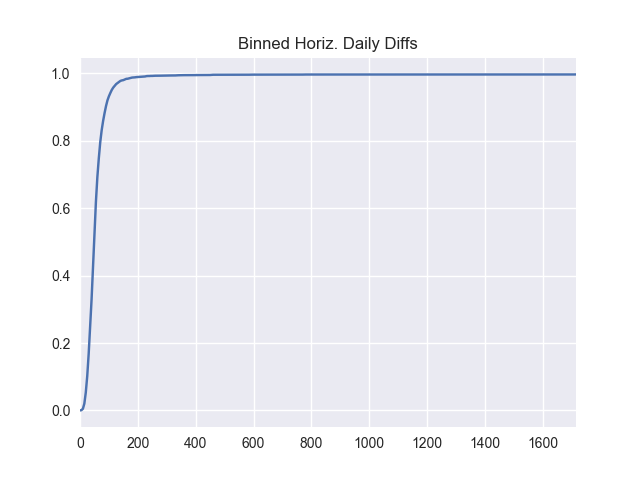

In [21]:
HMagDiffBin.plot(x=1,y=0,kind='line',title='Binned Horiz. Daily Diffs')

<IPython.core.display.Javascript object>


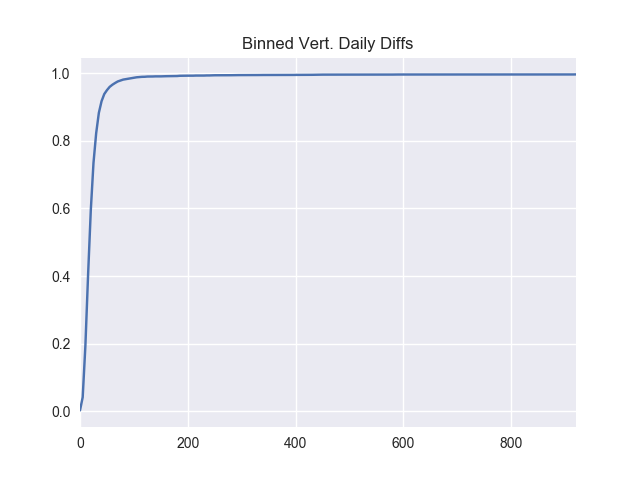

In [22]:
ZMagDiffBin.plot(x=1,y=0,kind='line',title='Binned Vert. Daily Diffs')

## Select the 90% 95% and 99% threshold values

In [23]:
# Plots look ok.  Get the tabular data to select the threshold values
HMagDiffBin.loc[85:210]

85     0.882615
90     0.903320
95     0.920260
100    0.932238
105    0.942163
110    0.951232
115    0.958077
120    0.963381
125    0.968344
130    0.971766
135    0.974846
140    0.977926
145    0.979295
150    0.980151
155    0.982204
160    0.983915
165    0.984257
170    0.985455
175    0.986482
180    0.987680
185    0.988022
190    0.988364
195    0.989049
200    0.989391
205    0.989904
210    0.990246
Name: HDailyDiff, dtype: float64

In [24]:
ZMagDiffBin.loc[35:125]

35     0.883128
40     0.917351
45     0.938398
50     0.950034
55     0.959617
60     0.965948
65     0.971081
70     0.975702
75     0.978611
80     0.981177
85     0.982546
90     0.984086
95     0.985455
100    0.986653
105    0.988022
110    0.988706
115    0.989391
120    0.989562
125    0.990246
Name: ZDailyDiff, dtype: float64

Horiz Thresholds (90%, 95% 99%): 90, 110, 210 (nT)

Vert Thresholds: 40, 50, 125 (nT)

## Create plots for the Horiz and Vert threshold exceedances

In [25]:
# Aggregate by months for 90% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 90].index.value_counts(sort=False)

1     39
2     23
3     39
4     52
5     60
6     73
7     90
8     96
9     73
10    57
11    47
12    22
dtype: int64

<IPython.core.display.Javascript object>


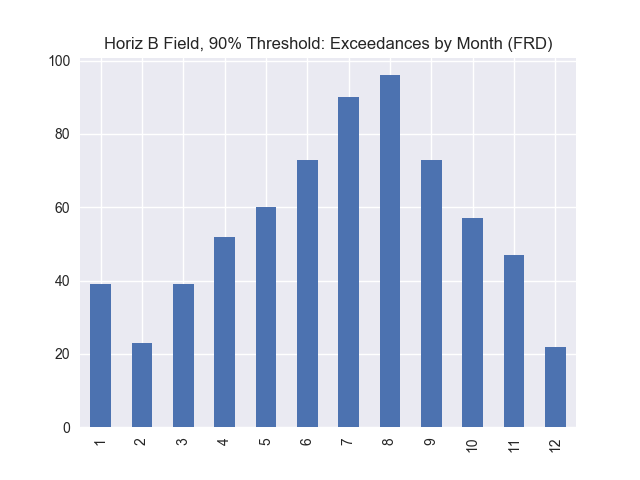

In [34]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 90].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 90% Threshold: Exceedances by Month (FRD)')

In [27]:
# Aggregate by months for 95% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 110].index.value_counts(sort=False)

1     17
2     10
3     20
4     32
5     28
6     37
7     39
8     36
9     35
10    34
11    23
12    10
dtype: int64

<IPython.core.display.Javascript object>


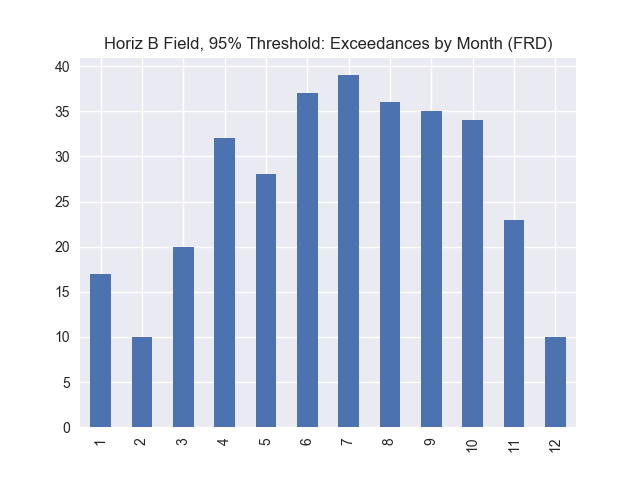

In [35]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 110].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 95% Threshold: Exceedances by Month (FRD)')

In [30]:
# Aggregate by months for 99% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 210].index.value_counts(sort=False)

1     1
3     2
4     4
5     6
6     2
7     7
8     3
9     3
10    5
11    7
12    2
dtype: int64

<IPython.core.display.Javascript object>


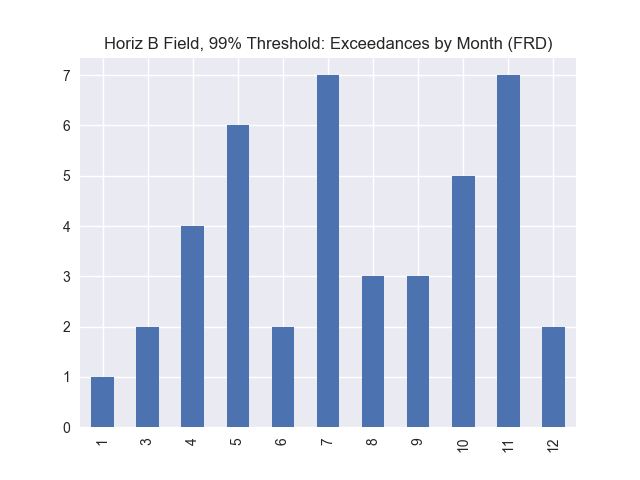

In [36]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 210].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 99% Threshold: Exceedances by Month (FRD)')

In [32]:
# Aggregate by months with no threshold (0%) - Vert. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 0].index.value_counts(sort=False).sort_index()

1     495
2     452
3     496
4     480
5     494
6     480
7     496
8     496
9     477
10    494
11    473
12    494
dtype: int64

<IPython.core.display.Javascript object>


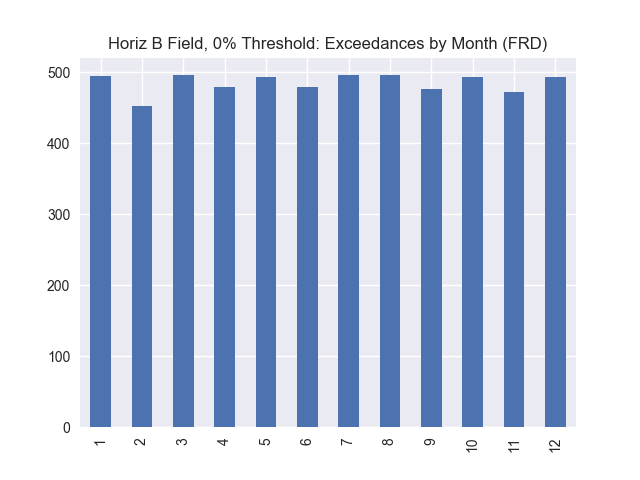

In [37]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 0].index.value_counts(sort=False).sort_index().plot(kind='bar',title='Horiz B Field, 0% Threshold: Exceedances by Month (FRD)')

In [38]:
# Aggregate by months for 90% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 40].index.value_counts(sort=False)

1      18
2      22
3      58
4      83
5      82
6      72
7     110
8      79
9      54
10     56
11     32
12      5
dtype: int64

<IPython.core.display.Javascript object>


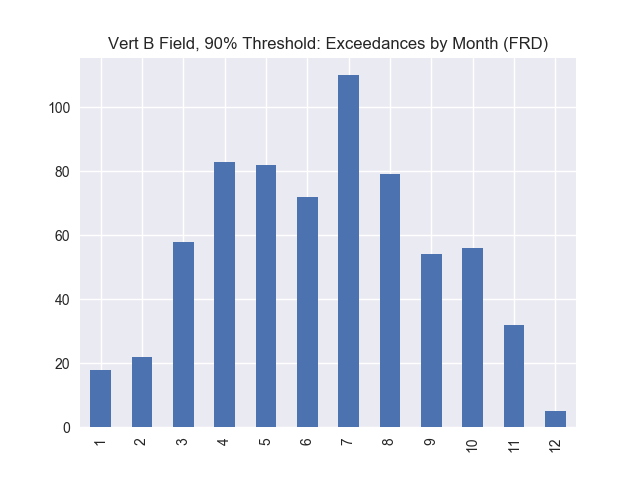

In [39]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 40].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 90% Threshold: Exceedances by Month (FRD)')

In [40]:
# Aggregate by months for 95% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 50].index.value_counts(sort=False)

1     11
2     10
3     26
4     41
5     36
6     34
7     50
8     39
9     33
10    36
11    23
12     2
dtype: int64

<IPython.core.display.Javascript object>


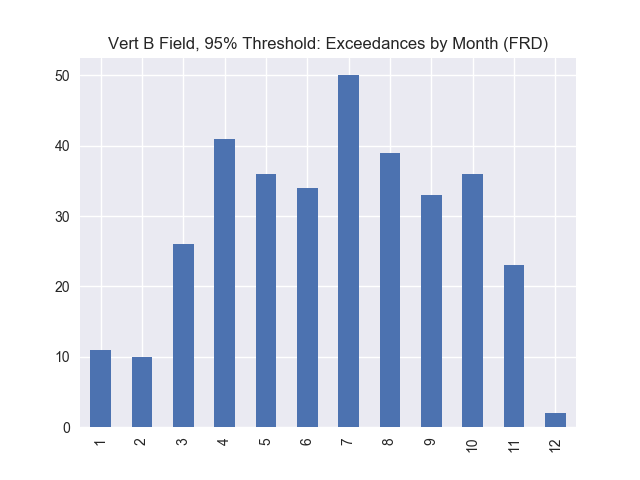

In [41]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 50].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 95% Threshold: Exceedances by Month (FRD)')

In [42]:
# Aggregate by months for 99% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 125].index.value_counts(sort=False)

2     2
3     1
4     4
5     3
7     5
8     5
9     5
10    7
11    8
12    1
dtype: int64

<IPython.core.display.Javascript object>


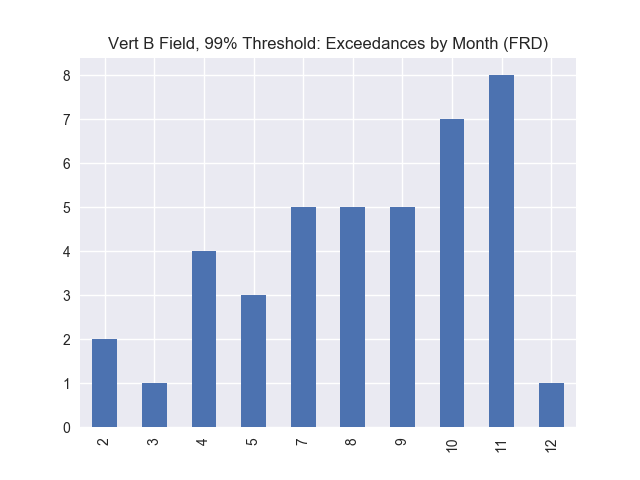

In [43]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 125].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 99% Threshold: Exceedances by Month (FRD)')

In [44]:
# Aggregate by months with no threshold (0%) - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 0].index.value_counts(sort=False).sort_index()

1     495
2     452
3     494
4     480
5     494
6     480
7     496
8     496
9     477
10    494
11    472
12    494
dtype: int64

<IPython.core.display.Javascript object>


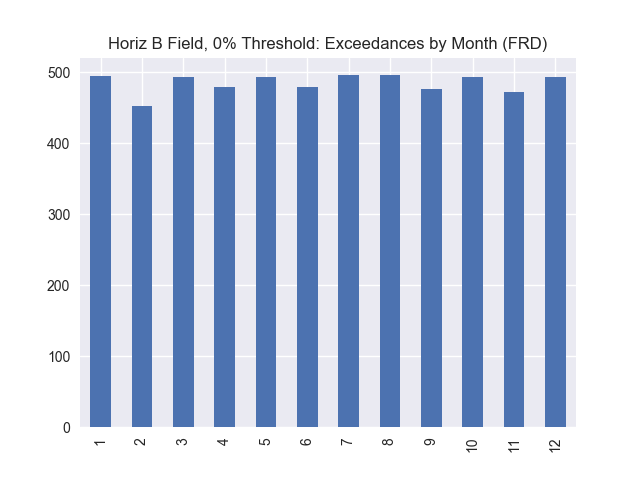

In [45]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 0].index.value_counts(sort=False).sort_index().plot(kind='bar',title='Horiz B Field, 0% Threshold: Exceedances by Month (FRD)')

# OTT Data (Vert. and Horiz.)

In [ ]:
### Must edit below...

In [48]:
# The range() function produces a list of values that does not include the stop value.
# So to get 1999 thru 2013 data, generate range of years with stop value 2013.
filelist=[]; # file list variable must exist before appending to it.
for year in range(1999,2014,1): filelist += glob.glob('./ott/' + str(year) + '/*') # append file strings from each year's folder

In [49]:
# Read each file's data into a list.  Index 0 is first file's data.  Lines starting with ' ' are ignored.
# First non-ignored line is data names, so header=0 will use this line to name the columns.
# Don't ingest col 2 (DOY); not useful to this analysis.  Combine the first two columns into a single DATETIME value
# and use it as the row index for the data set.  This command takes about 1 min.
filedata = [pd.read_csv(file, delim_whitespace=True, header=0, comment=' ', usecols=[0,1,3,4,5,6], parse_dates=[[0,1]], index_col=0) for file in filelist]

In [50]:
# Combine all the files into one big dataset.  Concat() is smart enough to create a union of all columns that 
# appear in the files, filling rows with NaN as needed.
data = pd.concat(filedata)

In [51]:
data.head()

,OTTF,OTTG,OTTX,OTTY,OTTZ
DATE_TIME,,,,,
1999-01-01 00:00:00,56327.8,NaN,16901.5,-4397.9,53551.8
1999-01-01 00:01:00,56327.9,NaN,16901.8,-4398.0,53551.9
1999-01-01 00:02:00,56328.0,NaN,16901.7,-4398.2,53552.0
1999-01-01 00:03:00,56327.8,NaN,16901.6,-4398.1,53551.9
1999-01-01 00:04:00,56327.8,NaN,16901.2,-4398.2,53551.9


In [52]:
# Replace all the 99999 and 88888 data with NaN values
data = data.replace([99999.0, 88888.0],[None,None])

In [53]:
data.to_pickle('./raw_concat_OTT_data')

In [55]:
# Create a new col for Horiz data.  There is no OTTH data in these files so Initially populate
# with NaN then fill with the RSS of FRDX and FRDY in next command.
data['HMag'] = None

In [56]:
data.loc[pd.notnull(data['OTTX']) &  pd.notnull(data['OTTY']),'HMag'] = np.sqrt(data['OTTX']**2 + data['OTTY']**2)

In [57]:
data.to_pickle('./OTT_data_HZcols')

In [58]:
# Create a range of dates to cover the period from the first entry's date to the last entry's date
day_range = pd.date_range(start=data.index[0], end=data.index[-1], freq='D')

In [59]:
# Create a list of HMag and OTTZ data where each element is an individual day.  I do this once so that
# the following max() min() calls don't have to find the same date range data twice.
# This command takes about 4.5+ min to run on my laptop.  Might've been faster to get max min for each file
# as it was read...
HZMagListByDay = [data.loc[(data.index >= day) & (data.index < day+1),['HMag','OTTZ']] for day in day_range]

In [60]:
# Create a data set of the daily max min differences for the HMag and OTTZ data.  Index rows by the month number.
HZMagDiff=pd.DataFrame([((np.max(HZMagListByDay[i]['HMag']) - np.min(HZMagListByDay[i]['HMag'])),
                         (np.max(HZMagListByDay[i]['OTTZ']) - np.min(HZMagListByDay[i]['OTTZ'])))
                        for i in range(0,len(HZMagListByDay))],
                        index=[day.month for day in day_range], columns=['HDailyDiff','ZDailyDiff'])

In [61]:
HZMagDiff.head()

,HDailyDiff,ZDailyDiff
1,32.995180,16.2
1,42.936156,13.5
1,25.943114,16.5
1,36.409789,30.3
1,47.851297,24.9


In [62]:
HZMagDiff.to_pickle('./OTT_data_HZDailyDiffs')

## Bin the OTT data

In [63]:
# Need to bin the data to get values where 90%, 95% and 99% quantiles are.
# So get max and min differences to see what binning scheme makes sense. 
HZMagDiff['HDailyDiff'].max()

2340.1091190042116

In [64]:
HZMagDiff['HDailyDiff'].min()

11.037345062755776

In [65]:
HZMagDiff['ZDailyDiff'].max()

2033.5999999999985

In [66]:
HZMagDiff['ZDailyDiff'].min()

3.0

In [67]:
# Bin the Horiz and Vert. data, then plot to see if it looks ok
HMagDiffBin = HZMagDiff['HDailyDiff'].value_counts(bins=range(0,2351,10),sort=False, normalize=True).cumsum()

In [68]:
ZMagDiffBin = HZMagDiff['ZDailyDiff'].value_counts(bins=range(0,2041,10),sort=False, normalize=True).cumsum()

<IPython.core.display.Javascript object>


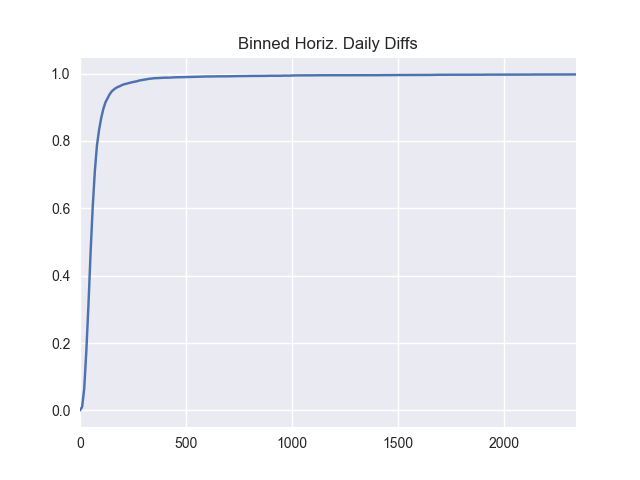

In [69]:
HMagDiffBin.plot(x=1,y=0,kind='line',title='Binned Horiz. Daily Diffs')

<IPython.core.display.Javascript object>


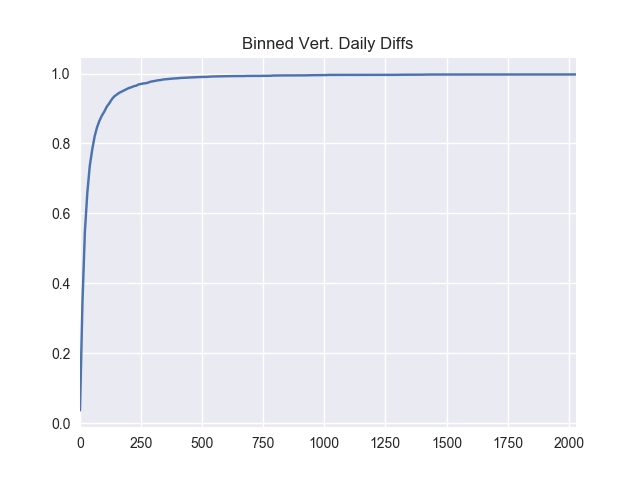

In [70]:
ZMagDiffBin.plot(x=1,y=0,kind='line',title='Binned Vert. Daily Diffs')

## Select the 90% 95% and 99% threshold values

In [73]:
# Plots look ok.  Get the tabular data to select the threshold values
HMagDiffBin.loc[100:540]

100    0.867677
110    0.894871
120    0.914400
130    0.926629
140    0.938675
150    0.947253
160    0.952729
170    0.957291
180    0.960577
190    0.963132
200    0.966417
210    0.968425
220    0.970068
230    0.971893
240    0.973170
250    0.974813
260    0.976091
270    0.977186
280    0.979376
290    0.980288
300    0.981566
310    0.982479
320    0.983756
330    0.984486
340    0.985399
350    0.986129
360    0.986311
370    0.986676
380    0.987041
390    0.987589
400    0.987771
410    0.987771
420    0.987771
430    0.988137
440    0.988319
450    0.988867
460    0.988867
470    0.989049
480    0.989232
490    0.989597
500    0.989597
510    0.989597
520    0.989962
530    0.990144
540    0.990327
Name: HDailyDiff, dtype: float64

In [74]:
ZMagDiffBin.loc[100:500]

100    0.891769
110    0.905640
120    0.914948
130    0.926081
140    0.934295
150    0.939588
160    0.944515
170    0.947983
180    0.951268
190    0.954736
200    0.958569
210    0.960577
220    0.963680
230    0.965140
240    0.968790
250    0.970068
260    0.971528
270    0.972258
280    0.974265
290    0.976821
300    0.977916
310    0.979376
320    0.980653
330    0.981383
340    0.982844
350    0.983574
360    0.984486
370    0.985216
380    0.985581
390    0.985946
400    0.986494
410    0.987224
420    0.987589
430    0.987954
440    0.988319
450    0.988684
460    0.989049
470    0.989414
480    0.989779
490    0.989962
500    0.990144
Name: ZDailyDiff, dtype: float64

Horiz Thresholds (90%, 95% 99%): 120, 160, 530 (nT)

Vert Thresholds: 110, 180, 500 (nT)

## Create plots for the Horiz and Vert threshold exceedances

In [75]:
# Aggregate by months for 90% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 120].index.value_counts(sort=False)

1     16
2      9
3     34
4     51
5     65
6     68
7     91
8     79
9     56
10    47
11    34
12    12
dtype: int64

<IPython.core.display.Javascript object>


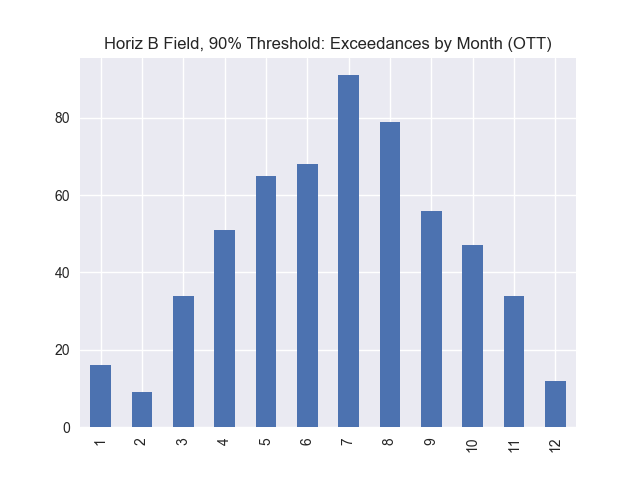

In [76]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 120].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 90% Threshold: Exceedances by Month (OTT)')

In [78]:
# Aggregate by months for 95% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 160].index.value_counts(sort=False)

1      7
2      3
3     19
4     27
5     31
6     39
7     35
8     33
9     28
10    33
11    17
12     3
dtype: int64

<IPython.core.display.Javascript object>


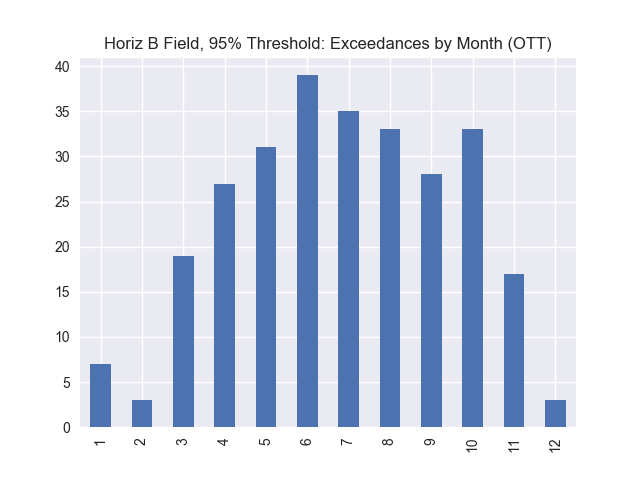

In [79]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 160].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 95% Threshold: Exceedances by Month (OTT)')

In [80]:
# Aggregate by months for 99% exceedances - Horiz. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 530].index.value_counts(sort=False)

1     1
3     2
4     6
5     4
7     5
8     3
9     5
10    8
11    6
12    1
dtype: int64

<IPython.core.display.Javascript object>


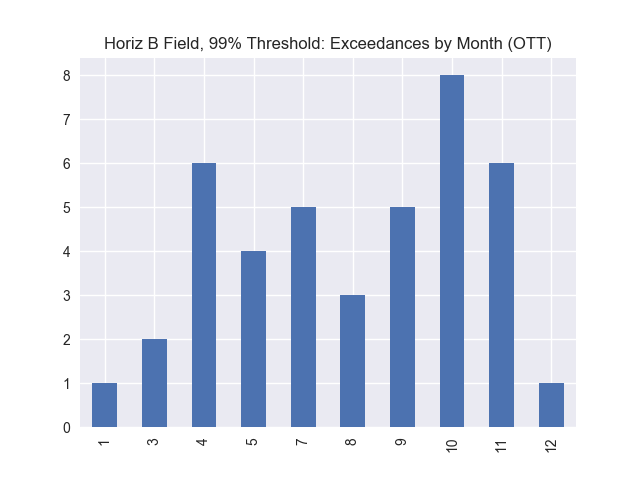

In [81]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 530].index.value_counts(sort=False).plot(kind='bar',title='Horiz B Field, 99% Threshold: Exceedances by Month (OTT)')

In [82]:
# Aggregate by months with no threshold (0%) - Vert. data
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 0].index.value_counts(sort=False).sort_index()

1     465
2     423
3     465
4     450
5     465
6     450
7     465
8     459
9     450
10    465
11    443
12    465
dtype: int64

<IPython.core.display.Javascript object>


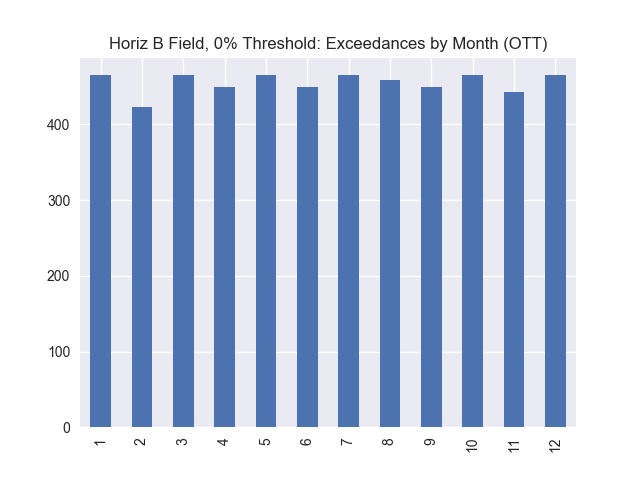

In [83]:
HZMagDiff.loc[HZMagDiff['HDailyDiff'] >= 0].index.value_counts(sort=False).sort_index().plot(kind='bar',title='Horiz B Field, 0% Threshold: Exceedances by Month (OTT)')

In [84]:
# Aggregate by months for 90% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 110].index.value_counts(sort=False)

1     24
2     18
3     54
4     67
5     62
6     47
7     65
8     60
9     64
10    62
11    44
12    14
dtype: int64

<IPython.core.display.Javascript object>


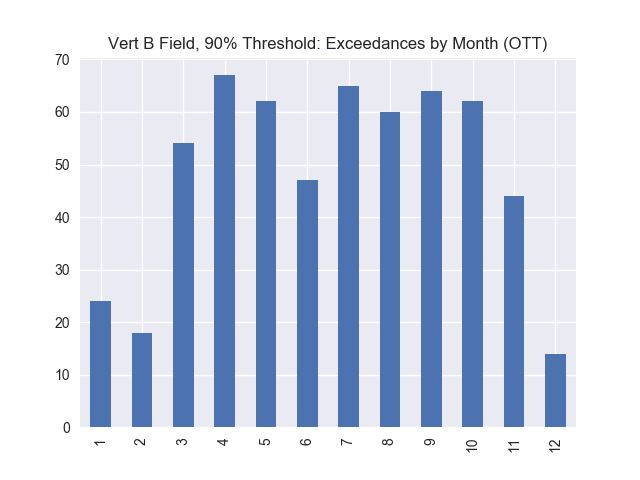

In [93]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 110].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 90% Threshold: Exceedances by Month (OTT)')

In [86]:
# Aggregate by months for 95% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 180].index.value_counts(sort=False)

1     12
2      8
3     22
4     30
5     30
6     19
7     26
8     32
9     25
10    39
11    24
12     4
dtype: int64

<IPython.core.display.Javascript object>


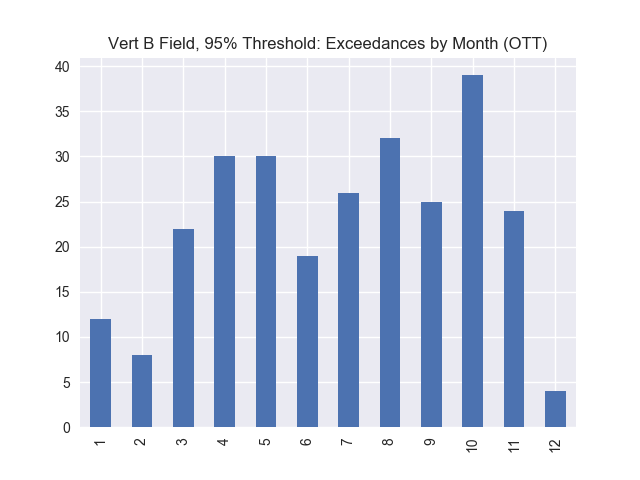

In [87]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 180].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 95% Threshold: Exceedances by Month (OTT)')

In [88]:
# Aggregate by months for 99% exceedances - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 500].index.value_counts(sort=False)

2     2
3     1
4     5
5     3
6     1
7     6
8     5
9     3
10    7
11    7
12    1
dtype: int64

<IPython.core.display.Javascript object>


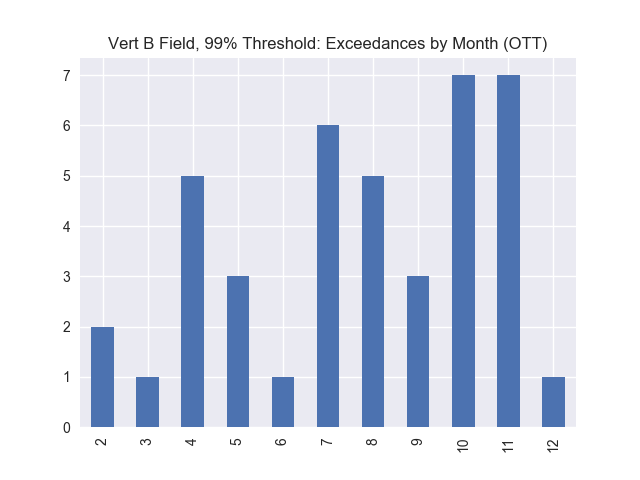

In [89]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 500].index.value_counts(sort=False).plot(kind='bar',title='Vert B Field, 99% Threshold: Exceedances by Month (OTT)')

In [90]:
# Aggregate by months with no threshold (0%) - Vert. data
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 0].index.value_counts(sort=False).sort_index()

1     465
2     423
3     465
4     450
5     465
6     450
7     465
8     459
9     450
10    465
11    443
12    465
dtype: int64

<IPython.core.display.Javascript object>


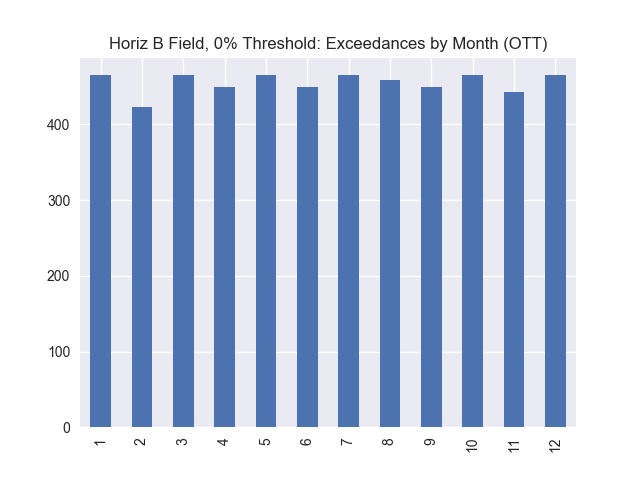

In [91]:
HZMagDiff.loc[HZMagDiff['ZDailyDiff'] >= 0].index.value_counts(sort=False).sort_index().plot(kind='bar',title='Horiz B Field, 0% Threshold: Exceedances by Month (OTT)')